# RA Project

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AIRO/EAI/RA/RAProject' # Francesco
#path = '/content/drive/MyDrive/RAProject' # Kevin
!ln -s $path /mydrive 
%cd /mydrive/nonmarkov-envs
#!pip install . >/dev/null
#!pip install graphviz

from nonmarkov_envs.rdp_env import RDPEnv
from nonmarkov_envs.specs.rotating_mab import RotatingMAB
from nonmarkov_envs.specs.rotating_maze import RotatingMaze
from nonmarkov_envs.specs.enemy_corridor import EnemyCorridor
from collections import defaultdict, Counter
import numpy as np, operator, math, random, graphviz

Mounted at /content/drive
/content/drive/MyDrive/AIRO/EAI/RA/RAProject/nonmarkov-envs


## Environment

### Initialization

In [2]:
#env_spec = RotatingMAB()
#env_spec = RotatingMaze()
env_spec = EnemyCorridor()

print("\n States: ", env_spec.STATES)
print("\n Actions: ", env_spec.ACTIONS)
print("\n Observations: ", env_spec.OBSERVATIONS)
print("\n Rewards: ", env_spec.REWARDS)
print("\n Transition function: ", env_spec.tau)
print("\n Reward function: ", env_spec.theta)
print("\n Initial state: ", env_spec.initial_state)
print("\n Terminal states: ", env_spec.terminal_states)

env = RDPEnv(env_spec, markovian=False, stop_prob=0.01, episode_length=100)
env.reset()

print('\n #########################################')

print("\n Simulation ->")
for step in range(15):
    a = env.action_space.sample() # take action from sample space
    o, r, d, i = env.step(a) # step function returns: observation, reward, done, info
    print("\nstep"+str(step)+": ", a, o, r, d, i)
    if d: break

print('\n #########################################')

n_hat = len(env_spec.tau)
initial_state = env.specification.initial_state
actions = env_spec.ACTIONS
print('\n Upper Bound on transducer states: {}'.format(n_hat))


 States:  {(0, 1), (0, 0), (3, 0), (3, 1), (2, 1), (2, 0), (1, 0), (1, 1)}

 Actions:  {0, 1}

 Observations:  {(0, 1), (0, 0), (3, 0), (3, 1), (2, 1), (2, 0), (1, 0), (1, 1)}

 Rewards:  {0, 100}

 Transition function:  {(0, 1): {(1, 0): (1, 1), (1, 1): (1, 0)}, (0, 0): {(1, 0): (1, 0), (1, 1): (1, 1)}, (3, 0): {(0, 1): (0, 1), (0, 0): (0, 0)}, (3, 1): {(0, 1): (0, 0), (0, 0): (0, 1)}, (2, 1): {(3, 0): (3, 1), (3, 1): (3, 0)}, (2, 0): {(3, 0): (3, 0), (3, 1): (3, 1)}, (1, 0): {(2, 1): (2, 1), (2, 0): (2, 0)}, (1, 1): {(2, 1): (2, 0), (2, 0): (2, 1)}}

 Reward function:  {(0, 1): {0: {(1, 0): {100: 0.6}, (1, 1): {0: 0.4}}, 1: {(1, 0): {100: 0.4}, (1, 1): {0: 0.6}}}, (0, 0): {0: {(1, 0): {100: 0.4}, (1, 1): {0: 0.6}}, 1: {(1, 0): {100: 0.6}, (1, 1): {0: 0.4}}}, (3, 0): {0: {(0, 1): {0: 0.6}, (0, 0): {100: 0.4}}, 1: {(0, 1): {0: 0.4}, (0, 0): {100: 0.6}}}, (3, 1): {0: {(0, 1): {0: 0.4}, (0, 0): {100: 0.6}}, 1: {(0, 1): {0: 0.6}, (0, 0): {100: 0.4}}}, (2, 1): {0: {(3, 0): {100: 0.9}, (3,

## Algorithm

### Preliminaries

#### Sampling

In [3]:
# return with a certain probability p the stop action and 1-p an action
def exploration_policy(env_spec, p_stop):
  actions = list(env_spec.ACTIONS)
  if p_stop:
    len_A = len(actions)
    actions += ['$'] # stop action
    p_action = (1-p_stop)/len_A
    return np.random.choice(actions, p=[p_action]*len_A+[p_stop])
  else:
    return np.random.choice(actions)

# generate a random episode until stop
def generate_episode(env, p_stop=None):
  # x: single episode
  env.reset()
  x = []
  while True:
    action = exploration_policy(env.specification, p_stop)
    if action == '$': 
      print('1ui')
      x.append(action)
      break
    a = int(action)
    o, r, d, _ = env.step(a)
    x.append(str(a)+str(o)+str(r))
    if d:
      x.append('$')
      break
  return x
 
# generate N examples i.i.d. from target PDFA
def draw_sample(env, N, p_stop=None, S=None):
  symbols = read_symbols(env.specification)
  mapping = symbol_mapping(symbols)
  S = [] if S is None else S
  for i in range(N):
    s = ''
    x = generate_episode(env, p_stop)
    for sym in x:
      s += mapping[sym]
    S.append(s)
  return S, mapping

def read_alphabet(S):
  alphabet = set()
  for episode in S:
    for s in episode[:-1]:
      alphabet.add(s)
  return alphabet

# return the set of possible symbols
def read_symbols(env_spec):
  theta = env_spec.theta
  symbols = set()
  for k in theta:
    for a in theta[k]:
      for o in theta[k][a]:
        for r in theta[k][a][o]:
          sym = str(a) + str(o) + str(r)
          symbols.add(sym)
  return symbols

def symbol_mapping(symbols):
  if isinstance(symbols, set):
    symbols = list(symbols)
  d = {str(symbols[i-66]):chr(i) for i in range(66, 66 + len(symbols))}
  d.update({'$': '$'})
  return d

#### AdaCT Helpers

In [4]:
######## FUNCTIONS ########

from itertools import combinations, product
def pairs(*lists):
  for t in combinations(lists, 2):
    for pair in product(*t):
      yield pair

def prefixes(m):
    return [s[:i] for s in m for i in range(len(s))]

def multiplicity(w, m):
  return sum(1 if s == w else 0 for s in m)

def supremum_distance(u, v, m_u, m_v):
  multiplicity_u = Counter(u)
  multiplicity_v = Counter(v)
  return max(abs(multiplicity_u[s]/m_u - multiplicity_v[s]/m_v) for s in (u + v))

def pref_supremum_distance(pref_u, pref_v, m_u, m_v):
  multiplicity_pu = Counter(pref_u)
  multiplicity_pv = Counter(pref_v)
  return max(abs(multiplicity_pu[s]/m_u - multiplicity_pv[s]/m_v) for s in (pref_u + pref_v))

def test_distinct(u, v, sigma, delta, n):
  pref_u, pref_v = prefixes(u), prefixes(v)
  m_u, s_u = len(u), len(pref_u)
  m_v, s_v = len(v), len(pref_v)
  delta_0 = delta/(n*(n*len(sigma) + len(sigma) + 1))
  t_uv = math.sqrt( (2/min(m_u, m_v)) * math.log(8*(s_u + s_v)/delta_0) )
  d = max(supremum_distance(u, v, m_u, m_v), pref_supremum_distance(pref_u, pref_v, m_u, m_v))
  if d > t_uv:
    return 'Distinct'
  else:
    return 'Not Clear'

######## CLASSES ########

class Symbol:
  def __init__(self, action: str, state: tuple, reward: int):
    self.action = action 
    self.state = state
    self.reward = reward

  def __repr__(self):
    return str(self)

  def __str__(self):
    return str(self.action) + str(self.state) + str(self.reward)

  def __eq__(self, other):
    if isinstance(other, Symbol):
      return self.action == other.action and self.state == other.state and self.reward == other.reward
    return False

  def __hash__(self):
    return hash(str(self))

  @staticmethod
  def from_str(sym):
    a = sym[:sym.find('(')]
    s = sym[sym.find('(')+1:sym.find(')')].split(',')
    s = tuple([int(ss) for ss in s if ss != ''])
    r = int(sym[sym.find(')')+1:])
    return Symbol(a, s, r)


class Node:
  def __init__(self, multiset=None, edges=None):
    self.multiset =  multiset if multiset else []
    self.edges = edges if edges else {}

  def __repr__(self):
    return 'Edges -> ' + str(self.edges) + ' Multiset length = ' + str(len(self.multiset))

  def __gt__(self, other):
    s, o = len(self.multiset), len(other.multiset)
    if s == o and s == 1:
      return len(self.multiset[0]) > len(other.multiset[0])
    else: 
      return s > o

  def copy(self):
    return Node(self.multiset.copy(), self.edges.copy())


class Graph:
  def __init__(self):
    self.graph = defaultdict(Node)

  def __getitem__(self, key):
    return self.graph[key]

  def __setitem__(self, key, node):
    self.graph[key] = node

  def __delitem__(self, key):
    del self.graph[key]

  def __contains__(self, key):
    return key in self.nodes()

  def __len__(self):
    return len(self.graph)

  def __iter__(self):
    return iter(k for k in self.graph.keys())

  def __index__(self, index):
    return self.graph.keys()[index]

  def __str__(self):
    return 'Graph' + str(self.nodes())

  def __repr__(self):
    ret = str(self) + '\n'
    for node in self.nodes():
      ret += '  Node {:<10}'.format(node) +str(self.graph[node]) + '\n'
    return ret

  def nodes(self):
    return [k for k in self.graph.keys()]

  def start_node(self):
    return self.nodes()[0]

  def view(self, env, sym_map, save=None):
    # graph
    g = graphviz.Digraph('pdfa', format='png')
    inv_sym_map = {v:k for k,v in sym_map.items()}

    for n in self.nodes():
      if n == self.start_node():
        g.attr('node', shape='doublecircle')
        g.node(n)    
        g.attr('node', shape='circle')
      g.node(n[-1])

    for n in self.nodes():
      for sym, next_state in self[n].edges.items():
        g.edge(n[-1], next_state[-1], label=inv_sym_map[sym])
    
    if save != None:
      g.render(filename='../graph/'+type(env.specification).__name__+'_'+save+'.pdfa.gv')
    return g

#### MDP

In [15]:
######## FUNCTIONS ########

def probability(sym, m):
  return multiplicity(sym, prefixes(m))/len(m)

def max_reward(alphabet, sym_map):
  inv_map = {v:k for k,v in sym_map.items()}
  return max(Symbol.from_str(inv_map[s]).reward for s in alphabet)
  
def policy_episode(env, t, pi, steps):
  env.reset()
  count = 0
  s = (0,)
  x = []
  for i in range(steps):
    a = pi[s]
    o, r, d, _ = env.step(a)
    x.append([a, o, r])
    if d: break
    s = t[s][o]
    count += 1
  return x, i+1

######## CLASSES ########

class MDP:
  def __init__(self, A, Q, R, T, S, gamma, p_stop, m, sym_map):
    self.A = A # actions
    self.Q = Q # states
    self.R = R # rewards
    self.T = T # transition function
    self.S = S # observation
    self.gamma = gamma # discount factor
    self.D = self._compute_dynamics(p_stop, m, sym_map) # dynamics function
    #self.q_0 = q_0 # initial state

  def _compute_dynamics(self, p_stop, m, sym_map):
    dynamics = {} #{state: {action : {next state : {reward : prob}}}}
    for q1 in self.Q:
      dynamics[q1] = {}
      for a in self.A: 
        dynamics[q1][a] = {}
        for q2 in self.Q: 
          dynamics[q1][a][q2] = {} 
          for r in self.R:
            # transitions q1 -axr-> q2
            l = [asr for asr,t in self.T[q1].items() if t == q2 and asr.action == str(a) and asr.reward == r]
            # sum of probabilities
            dynamics[q1][a][q2][r] = (len(self.A)/(1-p_stop))*sum(probability(sym_map[str(asr)], m[q1]) for asr in l)
      
    return dynamics
  
  def value_iteration(self, m):
    pi, V = {q:0 for q in self.Q}, [{q:0 for q in self.Q} for i in range(m)]
 
    for k in range(1, m):
      for q1 in self.Q:
          V[k][q1] = max(sum(self.D[q1][a][q2][r] * (r + self.gamma * V[k-1][q2]) 
                                for q2 in self.Q for r in self.R) for a in self.A)

    for q1 in self.Q:      
      pi[q1] = np.argmax([sum(self.D[q1][a][q2][r] * (r + self.gamma * V[k][q2]) 
                              for q2 in self.Q for r in self.R) for a in self.A])
    
    return pi, V

  def transducer(self):
    tau = {}
    for q in self.Q:
      tau[q] = {}
      for s in self.S:
        rand = [asr for asr in self.T[q] if asr.state == s]
        if len(rand) > 0:
          asr = np.random.choice(rand)
          tau[q][s] = self.T[q][asr]
    return tau

  def print_dynamics(self, ret=False):
      res = ""
      for q1 in self.Q:
        res += "Dynamics of the state {}\n".format(q1)
        for a in self.A:
          for q2 in self.Q:
            for r in self.R:
              if self.D[q1][a][q2][r] > 0:
                res += "Action {} Next state {} Probability {}\n".format(a, q2, self.D[q1][a][q2])
        res += "\n"
      return res if ret else print(res)

  def __repr__(self):
    repr = "MDP Configuration\n"
    repr += "States: {}\n".format(self.Q)
    repr += "Actions: {}\n".format(self.A)
    repr += "Rewards: {}\n".format(self.R)
    repr += "Gamma: {}\n".format(self.gamma)
    repr += "\nDynamics function:\n"
    repr += self.print_dynamics(True)
    return repr

  @staticmethod
  def compute_mdp(pdfa, alphabet, actions, gamma, p_stop, sym_map):
    inv_sym_map = {v:k for k,v in sym_map.items()}
    state_map = {n:(i,) for i,n in enumerate(pdfa.nodes())}
    states = set([s for s in state_map.values()])
    multisets = {state_map[n]:pdfa[n].multiset for n in pdfa}
    rewards = set([Symbol.from_str(inv_sym_map[a]).reward for a in alphabet])
    observations = {Symbol.from_str(inv_sym_map[a]).state for a in alphabet}
    transitions = {state_map[n]: {Symbol.from_str(inv_sym_map[sym]):state_map[e] for sym,e in pdfa[n].edges.items()} for n in pdfa}
    return MDP(actions, states, rewards, transitions, observations, gamma, p_stop, multisets, sym_map)

### AdaCT
```
inputs:
  sigma = alphabet 
  delta = confidence parameter
  n     = upper bound on the number of states
  S     = containing N examples drawn i.i.d. from some target PDFA T with at most n states.

output:
  G     = hypothesis graph
```

In [6]:
def AdaCT(sigma, delta, n_hat, S, debug=False):
  G = Graph() # init hypothesis graph
  G['A'] = Node(S)
  max_stages = n_hat*len(sigma) # maximum learning stages
  
  for i in range(max_stages):
    # create candidates
    candidates = {}
    for (node, sym) in pairs(G.nodes(), sigma):
      # check if transition exists
      if sym not in G[node].edges:
        state = node + sym
        candidates[state] = Node()
  
    # populate candidates multisets
    for sample in S:
      curr_node = G.start_node()
      for count, s in enumerate(sample[:-1]):
        # traverse graph  
        if s in G[curr_node].edges:
          curr_node = G[curr_node].edges[s]
        else:
          # if transition to candidate node exists
          state = curr_node + s
          if state in candidates:
            candidates[state].multiset.append(sample[count+1:])
          break

    # discard empty candidates
    candidates = {k:v for k,v in candidates.items() if len(v.multiset) > 0}
    
    # if there are no more candidates return
    if len(candidates) == 0:
      if debug: print("\n################# NO MORE CANDIDATES #################\n")
      return G

    if debug:
      print("\n################# STAGE "+ str(i) +" #################")
      print(G)
      print('Candidates --> ', {c:len(candidates[c].multiset) for c in candidates.keys()})
    
    # choose candidate node with maximum cardinality multiset
    candidate_node, candidate_obj = max(candidates.items(), key=operator.itemgetter(1))
    if debug: print('candidate node --> {}'.format(candidate_node))
    
    # check if safe nodes are distincts from candidate
    for safe_node in G:
      result = test_distinct(candidate_obj.multiset, G[safe_node].multiset, sigma, delta, n_hat)
      if result == 'Not Clear':
        not_clear_node = safe_node
        break
    if debug: print('Test --> {}'.format(result))

    index = len(candidate_node)-1 
    prev_node, sym = candidate_node[:index], candidate_node[index]
    # add new safe node to graph and corresponding edge
    if result == 'Distinct':
      G[prev_node].edges[sym] = candidate_node
      G[candidate_node] = candidate_obj.copy()
    # add a back edge to the unclear node 
    else:
      G[prev_node].edges[sym] = not_clear_node

  if debug: print("\n################# REACHED MAX STAGES #################\n")
  return G

#### Test

In [ ]:
S, sym_map = draw_sample(env, 30000)
print("\n Mapping: \n", sym_map)
alphabet = read_alphabet(S)
print("\n Alphabet: \n", alphabet)
G = AdaCT(alphabet, 0.1, n_hat, S, debug=True)

In [ ]:
G.view(env, sym_map)

### RL
```
inputs:
  A       = actions
  gamma   = discount factor
  epsilon = required precision
  delta   = confidence parameter

output:
  pi       = policy
  ti       = transducer
```

In [7]:
def RL(actions, gamma, epsilon, delta, env, samples, steps=1, np=1, stop=None):
  X, out = [], {}
  n_hat = len(env.specification.tau)
  p_stop = 1/(stop+1) if stop else 1/(10*n_hat+1)
  for i in range(steps):
    s = samples//steps*(i+1)
    print('step {} : {} samples'.format(i+1, s), end =" ")
    X, sym_map = draw_sample(env, samples//steps, None, X)
    #X, sym_map = draw_sample(env, samples//steps, p_stop, X)
    alphabet = read_alphabet(X)
    R_max = max_reward(alphabet, sym_map)
    out[s] = {}
    for p in range(np):
      print('\u03C0'+ str(p), end=" ")
      pdfa = AdaCT(alphabet, delta, n_hat, X)
      mdp = MDP.compute_mdp(pdfa, alphabet, actions, gamma, p_stop, sym_map)
      m = math.ceil(1/(1-gamma) * math.log(2*R_max/(epsilon*math.pow((1-gamma),2))))
      pi, _ = mdp.value_iteration(m)
      t = mdp.transducer()
      out[s][p] = {'pi': pi, 't': t, 'pdfa': pdfa, 'map': sym_map}    
    print('\n')
  return out

#### Test

In [ ]:
RL(actions, 0.1, 0.01, 0.1, env, samples=100)[100][0]

## Experiments

In [20]:
samples = 500      # samples drawn for AdaCT algorithm
steps = 10           # steps of rl in the number of samples
num_policies = 10     # n policies computed with n different graphs
stop = 15              # expected value of length of one episode (10 MAB, 15 Maze, N Enemy)
episodes = 1000       # number of episodes to run the policy

In [21]:
rl = RL(actions, 0.1, 0.01, 0.1, env, samples, steps, num_policies, stop)

step 1 : 50 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 2 : 100 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 3 : 150 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 4 : 200 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 5 : 250 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 6 : 300 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 7 : 350 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 8 : 400 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 9 : 450 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 

step 10 : 500 samples π0 π1 π2 π3 π4 π5 π6 π7 π8 π9 



In [22]:
avg_rewards = {}

for s in rl: # for all samples
  rewards = 0
  for p in rl[s]: # for all policies
    t = rl[s][p] # take transducer
    for k in range(episodes): # for num episodes
      e, steps = policy_episode(env, t['t'], t['pi'], stop) # run policy
      rewards += sum(r for (_,_,r) in e) / steps
  avg_rewards[s] = round(rewards/(num_policies*episodes), 2) # take the policies average

print("Average rewards per samples per steps in one episode:")
print(avg_rewards)
print('max (samples:reward) ->', max(avg_rewards.items(), key=operator.itemgetter(1)))

Average rewards per samples per steps in one episode:
{50: 63.52, 100: 63.07, 150: 63.32, 200: 63.26, 250: 63.47, 300: 63.3, 350: 62.92, 400: 63.13, 450: 63.43, 500: 63.44}
max (samples:reward) -> (50, 63.52)


**Plots**

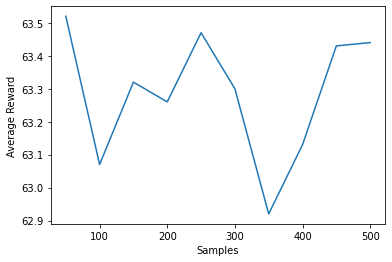

In [23]:
# Code for plotting (x = samples, y = avg_reward)
import matplotlib.pyplot as plt
%matplotlib inline

samples = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.ylabel('Average Reward')
plt.xlabel('Samples')
plt.plot(samples, rewards)

**View/Save graph**

In [ ]:
# take the graph yielding the maxium avg reward
max_samples = max(avg_rewards.items(), key=operator.itemgetter(1))[0]
_, _, max_pdfa, sym_map = rl[max_samples][random.randint(1, 10)].values()
max_pdfa.view(env, sym_map, save=str(max_samples))

## Debug Tests


In [ ]:
print(rl)

{200000: {0: {'pi': {(21,): 0, (32,): 0, (23,): 2, (34,): 1, (9,): 3, (36,): 3, (11,): 3, (38,): 1, (13,): 2, (24,): 1, (15,): 2, (26,): 1, (1,): 3, (28,): 1, (3,): 3, (30,): 0, (41,): 2, (5,): 3, (16,): 3, (43,): 1, (7,): 3, (18,): 1, (45,): 3, (20,): 0, (22,): 3, (33,): 0, (8,): 0, (35,): 0, (10,): 3, (37,): 2, (12,): 3, (39,): 0, (14,): 2, (25,): 1, (0,): 0, (27,): 2, (2,): 0, (29,): 0, (40,): 1, (4,): 3, (31,): 0, (42,): 0, (6,): 3, (17,): 2, (44,): 3, (19,): 2, (46,): 1}, 't': {(21,): {(3, 2): (0,), (3, 0): (0,), (3, 1): (0,), (2, 1): (0,)}, (32,): {(1, 2): (0,), (3, 2): (0,), (3, 1): (0,), (2, 1): (0,), (2, 0): (15,), (1, 1): (4,), (2, 3): (39,), (2, 2): (6,)}, (23,): {(0, 1): (18,), (1, 2): (28,), (1, 0): (31,), (2, 1): (32,)}, (34,): {(0, 1): (29,), (1, 2): (28,), (1, 0): (0,), (2, 1): (32,)}, (9,): {(0, 1): (18,), (0, 0): (9,), (1, 0): (10,)}, (36,): {(3, 0): (36,), (3, 1): (0,), (2, 0): (4,)}, (11,): {(0, 1): (0,), (0, 0): (9,), (1, 1): (15,), (0, 2): (0,)}, (38,): {(1, 2): (

In [ ]:
from collections import defaultdict, Counter
m = ['GBAFH', 'ABBCIE', 'CKI']
pm = prefixes(m)
mult_m, mult_pm = Counter(m), Counter(pm)
print(mult_m)
print(mult_m['G'])
print(mult_pm)
print(mult_pm['G'])

Counter({'GBAFH': 1, 'ABBCIE': 1, 'CKI': 1})
0
Counter({'': 3, 'G': 1, 'GB': 1, 'GBA': 1, 'GBAF': 1, 'A': 1, 'AB': 1, 'ABB': 1, 'ABBC': 1, 'ABBCI': 1, 'C': 1, 'CK': 1})
1


In [ ]:
u = ['AB$', 'AC$', 'AD$']
v = ['A$', 'AB$', 'B$', 'Z$']
pu, pv = prefixes(u), prefixes(v)
mu, mv = len(u), len(v)

print('sup distances')
print('u', u)
print('v', v)
sup = {str(s):abs(multiplicity(s, u)/mu - multiplicity(s, v)/mv) for s in (u + v)}
for k,va in sup.items():
  print(k[:-1], va)

print('\npref sup distances')
print('prefixes u', pu)
print('prefixes v', pv)
pref_sup = {str(s):abs(multiplicity(s, pu)/mu - multiplicity(s, pv)/mv) for s in (pu + pv)}
for k,va in pref_sup.items():
  print(k, va)

sup distances
u ['AB$', 'AC$', 'AD$']
v ['A$', 'AB$', 'B$', 'Z$']
AB 0.08333333333333331
AC 0.3333333333333333
AD 0.3333333333333333
A 0.25
B 0.25
Z 0.25

pref sup distances
prefixes u ['', 'A', 'AB', '', 'A', 'AC', '', 'A', 'AD']
prefixes v ['', 'A', '', 'A', 'AB', '', 'B', '', 'Z']
 0.0
A 0.5
AB 0.08333333333333331
AC 0.3333333333333333
AD 0.3333333333333333
B 0.25
Z 0.25


In [ ]:
prefixes(u)

['', 'A', '', 'A', '', 'A']

In [ ]:
# probability function
m = ['GBADCCFH', 'GACAHFGG', 'GCECEFEHAGHDC']

print(probability('G', m)) # 3/3
print(probability('GB', m)) # 1/3
print(probability('A', m)) # 0

1.0
0.3333333333333333
0.0


In [ ]:
alpha = ['a','b','c','d']
mul = [['a','b','b','d'], ['a','b','a','b','c'], ['a','c','d']]
pref = prefixes_graziano(mul)
print("Multiset in esame: ",mul,end='\n\n')
print("Considerando solo ed esclusivamente i prefixes di lunghezza 1 --- \nVettore di prefissi risultante\n----")
for p in pref:
  print(p)
print("----\nMolteplicità di b usando pref ",pref_multiplicity('b',pref))
#print("Molteplicità di b usando mult",multiplicity('b',pref))
print("Molteplicità di a usando pref ",pref_multiplicity('a',pref))
#print("Molteplicità di a usando mult",multiplicity('a',pref))


pref = prefixes(mul)


print("\n\nConsiderando tutti i prefixes --- \nVettore di prefissi risultante\n----")
for p in pref:
  print(p)
print("----\nMolteplicità di b usando pref ",pref_multiplicity('b',pref))
#print("Molteplicità di b usando mult",multiplicity('b',pref))
print("Molteplicità di a usando pref ",pref_multiplicity('a',pref))
#print("Molteplicità di a usando mult",multiplicity('a',pref))

Multiset in esame:  [['a', 'b', 'b', 'd'], ['a', 'b', 'a', 'b', 'c'], ['a', 'c', 'd']]

Considerando solo ed esclusivamente i prefixes di lunghezza 1 --- 
Vettore di prefissi risultante
----
a
a
a
----
Molteplicità di b usando pref  0
Molteplicità di a usando pref  3


Considerando tutti i prefixes --- 
Vettore di prefissi risultante
----
[]
['a']
['a', 'b']
['a', 'b', 'b']
['a', 'b', 'b', 'd']
[]
['a']
['a', 'b']
['a', 'b', 'a']
['a', 'b', 'a', 'b']
['a', 'b', 'a', 'b', 'c']
[]
['a']
['a', 'c']
['a', 'c', 'd']
----
Molteplicità di b usando pref  0
Molteplicità di a usando pref  12
